# Installation

The DAP is only compatible with Python3 at the moment.  You can get Python3 from https://www.python.org/ or you can install Anaconda from https://www.anaconda.com/download/.

To install the DAP, grab the code from the new SDSS git repository and run the setup script:

```
git clone https://github.com/sdss/mangadap.git
cd mangadap
git fetch
git checkout release-dr15
python3 setup.py install
```

You can see the python package dependencies, which the setup should try to install, in the `mangadap/requirements.txt` file:

```
# Package dependencies of the MaNGA DAP
numpy>=1.13.3
scipy>=1.0
matplotlib>=2.1.0
astropy>=2.0.2
pydl>=0.6.0
ppxf==6.7.8
vorbin==3.1.3
```

There's currently no DAP test suite, so we just have to try to run the code to see if it install correctly.

At the end of the installation you'll likely get warnings like these:

```
 UserWarning: MANGADRP_VER environmental variable undefined.  Default is: v2_4_3
 UserWarning: MANGA_SPECTRO_REDUX environmental variable undefined.  Default is: /Users/westfall/MaNGA/redux
 UserWarning: MANGADAP_VER environmental variable undefined.  Default is: 2.2.3dev
 UserWarning: MANGA_SPECTRO_ANALYSIS environmental variable undefined.  Default is: /Users/westfall/MaNGA/analysis
 UserWarning: MANGACORE_VER environmental variable undefined.  Default is: v1_6_2
 UserWarning: MANGACORE_DIR environmental variable undefined.  Default is: /Users/westfall/MaNGA/core/v1_6_2
```

This is telling you that the environment variables are not set, and that it will use the default values.  These warnings will also appear anytime you import the DAP.  The table below provides a description of these environmental variables.

| Key                       | Default                | Purpose |
|---------------------------|------------------------|---------|
| `$MANGADRP_VER`           | `v2_4_3`               | Sets DRP version used for some file names |
| `$MANGA_SPECTRO_REDUX`    | `$HOME/MaNGA/redux`    | Root directory with all reduced data |
| `$MANGADAP_VER`           | `mangadap.__version__` | Sets the DAP version *used to set the path to read/write any DAP output files.*  I.e., this does not reset the version of the code that will be used. |
| `$MANGA_SPECTRO_ANALYSIS` | `$HOME/MaNGA/analysis` | Root directory for all the analysis data |
| `$MANGACORE_VER`          | `v1_6_2`               | MaNGA CORE version (only needed for survey-level setup of the DAP) |
| `$MANGACORE_DIR`          | `$HOME/MaNGA/core/$MANGACORE_VER` | Directory with MaNGA CORE source (only needed for survey-level setup of the DAP |

These will be the values used if you don't redefine them in your environment.  You can do this by adding something similar to the following to your `.bash_profile` file.

```
export MANGADRP_VER=v2_4_3
export MANGA_SPECTRO_REDUX=/MY/MANGA/REDUX/PATH

export MANGADAP_VER=2.2.1
export MANGA_SPECTRO_ANALYSIS=/MY/MANGA/ANALYSIS/PATH

export MANGACORE_VER=v1_6_2
export MANGACORE_DIR=$HOME/Work/MaNGA/core/$MANGACORE_VER
```

**Note**: The DAP expects to find the `LOGCUBE` files to fit in `$MANGA_SPECTRO_REDUX/$MANGADRP_VER/*/stack` and it will write output to `$MANGA_SPECTRO_ANALYSIS/$MANGADRP_VER/$MANGADAP_VER/`.


In [6]:
import mangadap
print(mangadap.__file__)

/Users/westfall/Work/MaNGA/dap/repo/mangadap/python/mangadap/__init__.py


# Fitting one datacube

You can fit any datacube using the code in the following few cells.

In [2]:
import os
import numpy
import astropy.constants
from astropy.io import fits

from mangadap.survey.manga_dap import manga_dap
from mangadap.par.obsinput import ObsInputPar
from mangadap.par.analysisplan import AnalysisPlan, AnalysisPlanSet

In [3]:
def get_obsinput(plt, ifu, drpall_file=None):
    """
    Grab the input parameters the DAP requires for each observation to
    fit a cube.  If the drpall file is None, use the default path.
    """
    hdu = fits.open(os.path.join(os.environ['MANGA_SPECTRO_REDUX'], os.environ['MANGADRP_VER'],
                                 'drpall-{0}.fits'.format(os.environ['MANGADRP_VER']))) \
                if drpall_file is None else fits.open(drpall_file)
    indx = hdu[1].data['PLATEIFU'] == '{0}-{1}'.format(plt, ifu)

    return ObsInputPar(plt, ifu, mode='CUBE',
                       vel=astropy.constants.c.to('km/s').value*hdu[1].data['NSA_Z'][indx][0],
                       vdisp=100.,
                       ell=1-hdu[1].data['NSA_ELPETRO_BA'][indx][0],
                       pa=hdu[1].data['NSA_ELPETRO_PHI'][indx][0],
                       reff=hdu[1].data['NSA_ELPETRO_TH50_R'][indx][0])

In [4]:
def fit_one_cube(plt, ifu, drpall_file=None, directory_path=None, analysis_path=None):
    # Grab the required input parameters
    obs = get_obsinput(plt, ifu, drpall_file=drpall_file)

    # Define how you want to analyze the data
    plan = AnalysisPlanSet([ AnalysisPlan(drpqa_key='SNRG',
                                          bin_key='HYB10',
                                          continuum_key='SEOUL',
                                          elmom_key='EMOMM',
                                          elfit_key='EFITMDB',
                                          spindex_key='INDXEN') ])

    # Run it!
    return manga_dap(obs, plan, verbose=2, directory_path=directory_path,
                     analysis_path=analysis_path)

In [5]:
fit_one_cube(7815, 3702, drpall_file='./data/drpall-v2_4_3.fits',
             directory_path='./data', analysis_path='./output')

INFO     ::  --------------------------------------------------
INFO     ::             MaNGA Data Analysis Pipeline           
INFO     ::  --------------------------------------------------
INFO     ::     VERSION: 2.2.3dev
INFO     ::       START: Fri 22 Jun 2018 09:58:58
INFO     ::       PLATE: 7815
INFO     ::   IFUDESIGN: 3702
INFO     ::     3D MODE: CUBE
INFO     ::     N PLANS: 1
INFO     ::  --------------------------------------------------
INFO     ::   Opened DRP file: ./data/manga-7815-3702-LOGCUBE.fits.gz

INFO     ::  --------------------------------------------------
INFO     ::                        Plan 1                      
INFO     ::  --------------------------------------------------
INFO     ::      METHOD: HYB10-GAU-MILESHC
INFO     ::      OUTPUT: ./output/HYB10-GAU-MILESHC/7815/3702
INFO     ::  REF OUTPUT: ./output/HYB10-GAU-MILESHC/7815/3702/ref
INFO     ::  --------------------------------------------------
INFO     ::          REDUCTION ASSESSMENT COM

Read covariance cube:
       output type: Correlation
        dimensions: 2
             shape: (1764, 1764)
   non-zero values: 32314


Read covariance cube:
       output type: Correlation
        dimensions: 3
             shape: (497, 497, 11)
    pseudo-indices:  [   0  456  912 1368 1824 2281 2737 3193 3649 4105]
   non-zero values: 183735
Input covariance matrix (or elements) must be csr_matrices.


INFO     ::  --------------------------------------------------
INFO     ::  --------------------------------------------------
INFO     ::              STELLAR CONTINUUM FITTING             
INFO     ::  --------------------------------------------------
INFO     ::  Number of binned spectra: 497
INFO     ::  With good S/N and to fit: 497
INFO     ::  Determining initial guess kinematics
INFO     ::  Instantiating template library...
INFO     ::  --------------------------------------------------
INFO     ::  Template library output path: ./output/common/7815/3702
INFO     ::  Template library output file: manga-7815-3702-MILESHC.fits.gz
INFO     ::  Found 42 MILESHC templates
INFO     ::  Maximum number of wavelength channels: 4300
INFO     ::  Attempting to build raw data ...
INFO     ::  ... done
INFO     ::  Matching sampling ... 
INFO     ::  ... done
INFO     ::  After resampling (target): 2.4999999999999998e-05
INFO     ::  After resampling (calculated): 2.499999999999995e-05
I

Transfer Matrix Done                     


Transfer Matrix Done                     


Transfer Matrix Done                     


Transfer Matrix Done                     


INFO     ::  Writing: ./output/HYB10-GAU-MILESHC/7815/3702/manga-7815-3702-MAPS-HYB10-GAU-MILESHC.fits
INFO     ::  Compressing: ./output/HYB10-GAU-MILESHC/7815/3702/manga-7815-3702-MAPS-HYB10-GAU-MILESHC.fits.gz
INFO     ::  --------------------------------------------------
INFO     ::  --------------------------------------------------
INFO     ::            CONSTRUCTING OUTPUT MODEL CUBE          
INFO     ::  --------------------------------------------------
INFO     ::  Output path: ./output/HYB10-GAU-MILESHC/7815/3702
INFO     ::  Output file: manga-7815-3702-LOGCUBE-HYB10-GAU-MILESHC.fits.gz
INFO     ::  Output cubes have shape (42, 42, 4563)
INFO     ::  Constructing binned spectra datacube ...
a string value was expected.
INFO     ::  Constructing stellar continuum datacube ...
a string value was expected.
INFO     ::  Constructing emission-line model datacube ...
a string value was expected.
a string value was expected.
a string value was expected.
INFO     ::  Writing: ./o

0

# DAP Structure

The DAP is loosely structured as follows:

 1. **Wrapper classes**: Primarily handles the DAP data model.  Strong tie to MaNGA data format.
 2. **Primary computational classes**: Performs the fitting.  Generally applicable
 3. **Low-level functions**: Even more generally applicable function that perform single, specific tasks.
 
The main wrapper classes are those that perform the main analysis steps for the dap:
 - `ReductionAssessments`: Performs some basic assessments of the datacube
 - `SpatiallyBinnedSpectra`: Stacks the spectra according to a chosen binning method
 - `StellarContinuumModel`: Determines the best-fitting stellar continuum model for 
 - `EmissionLineMoments`: Measures the 0th, 1st, and 2nd moments of a set of emission lines
 - `EmissionLineModel`: Models the emission lines with parameterized functions.
 - `SpectralIndices`: Measures absorption-line and bandhead indices
 
A run of the DAP is an iteration through constructing instances of these objects for a given set of parameters.  The state of the object construction is saved as a "reference" file and the collection of constructed obects are used at the end of each iteration to construct the primary outputs of the DAP, the `MAPS` and model `LOGCUBE` files.  So we can construct a function equal to `fit_one_cube` above that explicitly calls the internal DAP classes.  To do that, we have to import all the necessary classes and functions.

In [7]:
from mangadap.config import defaults
from mangadap.drpfits import DRPFits
from mangadap.dapfits import construct_maps_file, construct_cube_file
from mangadap.proc.reductionassessments import ReductionAssessment
from mangadap.proc.spatiallybinnedspectra import SpatiallyBinnedSpectra
from mangadap.proc.stellarcontinuummodel import StellarContinuumModel
from mangadap.proc.emissionlinemoments import EmissionLineMoments
from mangadap.proc.emissionlinemodel import EmissionLineModel
from mangadap.proc.spectralindices import SpectralIndices

In [8]:
def fit_one_cube_explicit(plt, ifu, drpall_file=None, directory_path=None, analysis_path=None):
    # Grab the required input parameters
    obs = get_obsinput(plt, ifu, drpall_file=drpall_file)
    
    plan = AnalysisPlan(drpqa_key='SNRG', bin_key='HYB10', continuum_key='GAU-MILESHC',
                        elmom_key='EMOMM', elfit_key='EFITMDB', spindex_key='INDXEN')

    # Set the the analysis path and make sure it exists
    _analysis_path = defaults.default_analysis_path() \
                        if analysis_path is None else analysis_path
    if not os.path.isdir(_analysis_path):
        os.makedirs(_analysis_path)

    # Set the nsa redshift
    nsa_redshift = obs['vel']/astropy.constants.c.to('km/s').value

    # Define the analysis method and the output directories
    method = defaults.default_dap_method(plan=plan)
    method_dir = defaults.default_dap_method_path(method, plate=obs['plate'],
                                                  ifudesign=obs['ifudesign'],
                                                  analysis_path=_analysis_path)
    method_ref_dir = defaults.default_dap_method_path(method, plate=obs['plate'],
                                                      ifudesign=obs['ifudesign'], ref=True,
                                                      analysis_path=_analysis_path)

    #-------------------------------------------------------------------
    # Read the DRP file
    drpf = DRPFits(obs['plate'], obs['ifudesign'], obs['mode'], 
                   directory_path=directory_path, read=True)

    # Test if the RSS file exists
    drpf_rss = DRPFits(obs['plate'], obs['ifudesign'], 'RSS', directory_path=directory_path,
                       read=False)
    if not os.path.isfile(drpf_rss.file_path()):
        warnings.warn('RSS counterpart not available.  Some functionality may be limited!')
    del drpf_rss

    #---------------------------------------------------------------
    # S/N Assessments
    rdxqa = ReductionAssessment(plan['drpqa_key'], drpf, pa=obs['pa'], ell=obs['ell'],
                                analysis_path=_analysis_path, symlink_dir=method_ref_dir,
                                clobber=plan['drpqa_clobber'])

    #---------------------------------------------------------------
    # Spatial Binning
    binned_spectra = SpatiallyBinnedSpectra(plan['bin_key'], drpf, rdxqa, reff=obs['reff'],
                                            analysis_path=_analysis_path,
                                            symlink_dir=method_ref_dir,
                                            clobber=plan['bin_clobber'])

    #---------------------------------------------------------------
    # Stellar Continuum Fit
    stellar_continuum = StellarContinuumModel(plan['continuum_key'], binned_spectra,
                                              guess_vel=obs['vel'], guess_sig=obs['vdisp'],
                                              analysis_path=_analysis_path,
                                              tpl_symlink_dir=method_ref_dir,
                                              clobber=plan['continuum_clobber'])

    #---------------------------------------------------------------
    # Emission-line Moment measurements
    emission_line_moments = EmissionLineMoments(plan['elmom_key'], binned_spectra,
                                                stellar_continuum=stellar_continuum,
                                                redshift=nsa_redshift,
                                                analysis_path=_analysis_path,
                                                clobber=plan['elmom_clobber'])

    #---------------------------------------------------------------
    # Emission-line Fit
    emission_line_model = EmissionLineModel(plan['elfit_key'], binned_spectra,
                                            stellar_continuum=stellar_continuum,
                                            emission_line_moments=emission_line_moments,
                                            dispersion=100.0,
                                            minimum_error=numpy.finfo(numpy.float32).eps,
                                            analysis_path=_analysis_path,
                                            clobber=plan['elfit_clobber'])

    #---------------------------------------------------------------
    # If requested by the emission-line moments method, remeasure
    # the moments after the emission-line modeling.  This will
    # produce a new reference file that will have a different name
    # than the one produced above.
    if emission_line_moments.database['redo_postmodeling']:
        emission_line_moments.measure(binned_spectra, stellar_continuum=stellar_continuum,
                                      emission_line_model=emission_line_model,
                                      analysis_path=_analysis_path,
                                      clobber=plan['elmom_clobber'])

    #---------------------------------------------------------------
    # Spectral-Index Measurements
    spectral_indices = SpectralIndices(plan['spindex_key'], binned_spectra,
                                       redshift=nsa_redshift,
                                       stellar_continuum=stellar_continuum,
                                       emission_line_model=emission_line_model,
                                       analysis_path=_analysis_path,
                                       tpl_symlink_dir=method_ref_dir,
                                       clobber=plan['spindex_clobber'])

    #-------------------------------------------------------------------
    # Construct the main output files
    construct_maps_file(drpf, obs=obs, rdxqa=rdxqa, binned_spectra=binned_spectra,
                        stellar_continuum=stellar_continuum,
                        emission_line_moments=emission_line_moments,
                        emission_line_model=emission_line_model,
                        spectral_indices=spectral_indices, nsa_redshift=nsa_redshift,
                        analysis_path=_analysis_path, clobber=True, single_precision=True)

    construct_cube_file(drpf, obs=obs, binned_spectra=binned_spectra,
                        stellar_continuum=stellar_continuum,
                        emission_line_model=emission_line_model,
                        analysis_path=_analysis_path, clobber=True, single_precision=True)


In [9]:
fit_one_cube_explicit(7815, 3702, drpall_file='./data/drpall-v2_4_3.fits',
                      directory_path='./data', analysis_path='./output')

--------------------------------------------------
        REDUCTION ASSESSMENT COMPUTATIONS         
--------------------------------------------------
Output path: ./output/common/7815/3702
Output file: manga-7815-3702-SNRG.fits.gz
Reading exiting file
Read covariance cube:
       output type: Correlation
        dimensions: 2
             shape: (1764, 1764)
   non-zero values: 32314
--------------------------------------------------
--------------------------------------------------
            SPATIALLY BINNING SPECTRA             
--------------------------------------------------
Total spectra: 1764
With 80% spectral coverage: 773
With good S/N: 839
Number of good spectra: 773
Galactic extinction law: ODonnell
Galactic E(B-V) = 0.101375
Galactic R(V): 3.1
Output path: ./output/common/7815/3702
Output file: manga-7815-3702-SNRG-HYB10.fits.gz
Reading existing file


Read covariance cube:
       output type: Correlation
        dimensions: 3
             shape: (497, 497, 11)
    pseudo-indices:  [   0  456  912 1368 1824 2281 2737 3193 3649 4105]
   non-zero values: 183735
Input covariance matrix (or elements) must be csr_matrices.
--------------------------------------------------
--------------------------------------------------
            STELLAR CONTINUUM FITTING             
--------------------------------------------------
Number of binned spectra: 497
With good S/N and to fit: 497
Determining initial guess kinematics
Instantiating template library...
--------------------------------------------------
Template library output path: ./output/common/7815/3702
Template library output file: manga-7815-3702-MILESHC.fits.gz
Found 42 MILESHC templates
Maximum number of wavelength channels: 4300
Attempting to build raw data ...
... done
Matching sampling ... 
... done
After resampling (target): 2.4999999999999998e-05
After resampling (calculated):

--------------------------------------------------
--------------------------------------------------
              EMISSION-LINE MOMENTS               
--------------------------------------------------
--------------------------------------------------
Measurements for binned spectra
Using stellar continuum from stellar-continuum model fit.
Number of spectra: 497
With good S/N and to measure: 497
Output path: ./output/HYB10-GAU-MILESHC/7815/3702/ref
Output file: manga-7815-3702-SNRG-HYB10-GAU-MILESHC-EMOMM.fits.gz
Using existing file
--------------------------------------------------
--------------------------------------------------
          EMISSION-LINE PROFILE FITTING           
--------------------------------------------------
Number of binned spectra: 497
With good S/N and to fit: 497
Bins deconstructed in fitting: True
Output path: ./output/HYB10-GAU-MILESHC/7815/3702/ref
Output file: manga-7815-3702-SNRG-HYB10-GAU-MILESHC-EFITMDB.fits.gz
Using existing file


a string value was expected.
a string value was expected.


--------------------------------------------------
--------------------------------------------------
              EMISSION-LINE MOMENTS               
--------------------------------------------------
--------------------------------------------------
Measurements for unbinned spaxels
Using stellar continuum from emission-line model fit.
Number of spectra: 1764
With good S/N and to measure: 773
Output path: ./output/HYB10-GAU-MILESHC/7815/3702/ref
Output file: manga-7815-3702-SNRG-HYB10-GAU-MILESHC-EFITMDB-EMOMM.fits.gz
Using existing file
--------------------------------------------------
--------------------------------------------------
           SPECTRAL-INDEX MEASUREMENTS            
--------------------------------------------------
Measurements for unbinned spaxels
Number of spectra: 1764
With good S/N and to measure: 773
Output path: ./output/HYB10-GAU-MILESHC/7815/3702/ref
Output file: manga-7815-3702-SNRG-HYB10-GAU-MILESHC-EFITMDB-INDXEN.fits.gz
Using existing file
------

a string value was expected.


Transfer Matrix Done                     


Transfer Matrix Done                     


Transfer Matrix Done                     


Transfer Matrix Done                     
Writing: ./output/HYB10-GAU-MILESHC/7815/3702/manga-7815-3702-MAPS-HYB10-GAU-MILESHC.fits
Compressing: ./output/HYB10-GAU-MILESHC/7815/3702/manga-7815-3702-MAPS-HYB10-GAU-MILESHC.fits.gz
--------------------------------------------------
--------------------------------------------------
          CONSTRUCTING OUTPUT MODEL CUBE          
--------------------------------------------------
Output path: ./output/HYB10-GAU-MILESHC/7815/3702
Output file: manga-7815-3702-LOGCUBE-HYB10-GAU-MILESHC.fits.gz
Output cubes have shape (42, 42, 4563)
Constructing binned spectra datacube ...


a string value was expected.
a string value was expected.


Constructing stellar continuum datacube ...
Constructing emission-line model datacube ...


a string value was expected.
a string value was expected.
a string value was expected.


Writing: ./output/HYB10-GAU-MILESHC/7815/3702/manga-7815-3702-LOGCUBE-HYB10-GAU-MILESHC.fits
Compressing: ./output/HYB10-GAU-MILESHC/7815/3702/manga-7815-3702-LOGCUBE-HYB10-GAU-MILESHC.fits.gz
--------------------------------------------------


# Performing a subset of the analysis

If you only want to execute some subset of the analysis steps, than you can set the relevant analysis keyword to `None` in the `AnalysisPlan` that's constructed in `fit_one_cube` or just set the relevant object to `None` in `fit_one_cube_explicit`.

**WARNING**: 
 - This currently doesn't work as it should because I haven't debugged this functionality much.  I think the only step that you can effectively skip is the spectral index measurements.
 - The instantiation of the classes use keyword arguments for optional input, and positional arguments for required arguments.  But it's best if you think of the 6 wrapper classes as being executed in sequence.

In [ ]:
def fit_one_cube_only_stellar_kinematics(plt, ifu, drpall_file=None, directory_path=None,
                                         analysis_path=None):
    
    # Grab the required input parameters
    obs = get_obsinput(plt, ifu, drpall_file=drpall_file)
    
    plan = AnalysisPlan(drpqa_key='SNRG', bin_key='HYB10', continuum_key='GAU-MILESHC',
                        elmom_key='EMOMM', elfit_key='EFITMDB', spindex_key='INDXEN')

    # Set the the analysis path and make sure it exists
    _analysis_path = defaults.default_analysis_path() \
                        if analysis_path is None else analysis_path
    if not os.path.isdir(_analysis_path):
        os.makedirs(_analysis_path)

    # Set the nsa redshift
    nsa_redshift = obs['vel']/astropy.constants.c.to('km/s').value

    # Define the analysis method and the output directories
    method = defaults.default_dap_method(plan=plan)
    method_dir = defaults.default_dap_method_path(method, plate=obs['plate'],
                                                  ifudesign=obs['ifudesign'],
                                                  analysis_path=_analysis_path)
    method_ref_dir = defaults.default_dap_method_path(method, plate=obs['plate'],
                                                      ifudesign=obs['ifudesign'], ref=True,
                                                      analysis_path=_analysis_path)

    #-------------------------------------------------------------------
    # Read the DRP file
    drpf = DRPFits(obs['plate'], obs['ifudesign'], obs['mode'], 
                   directory_path=directory_path, read=True)

    # Test if the RSS file exists
    drpf_rss = DRPFits(obs['plate'], obs['ifudesign'], 'RSS', directory_path=directory_path,
                       read=False)
    if not os.path.isfile(drpf_rss.file_path()):
        warnings.warn('RSS counterpart not available.  Some functionality may be limited!')
    del drpf_rss

    #---------------------------------------------------------------
    # S/N Assessments
    rdxqa = ReductionAssessment(plan['drpqa_key'], drpf, pa=obs['pa'], ell=obs['ell'],
                                analysis_path=_analysis_path, symlink_dir=method_ref_dir,
                                clobber=plan['drpqa_clobber'])

    #---------------------------------------------------------------
    # Spatial Binning
    binned_spectra = SpatiallyBinnedSpectra(plan['bin_key'], drpf, rdxqa, reff=obs['reff'],
                                            analysis_path=_analysis_path,
                                            symlink_dir=method_ref_dir,
                                            clobber=plan['bin_clobber'])

    #---------------------------------------------------------------
    # Stellar Continuum Fit
    stellar_continuum = StellarContinuumModel(plan['continuum_key'], binned_spectra,
                                              guess_vel=obs['vel'], guess_sig=obs['vdisp'],
                                              analysis_path=_analysis_path,
                                              tpl_symlink_dir=method_ref_dir,
                                              clobber=plan['continuum_clobber'])
    
    #-------------------------------------------------------------------
    # Construct the main output files
    construct_maps_file(drpf, obs=obs, rdxqa=rdxqa, binned_spectra=binned_spectra,
                        stellar_continuum=stellar_continuum, nsa_redshift=nsa_redshift,
                        analysis_path=_analysis_path, clobber=True, single_precision=True)

#    construct_cube_file(drpf, obs=obs, binned_spectra=binned_spectra,
#                        stellar_continuum=stellar_continuum,
#                        analysis_path=_analysis_path, clobber=True, single_precision=True)


In [ ]:
fit_one_cube_only_stellar_kinematics(7815, 3702, drpall_file='./data/drpall-v2_4_3.fits',
                                     directory_path='./data', analysis_path='./output')

# Changing the analysis methodology

Each wrapper class has an associated set of parameters that define how the data is analyzed, with object names like `StellarContinuumModelDef` for the `StellarContinuumModel` class.  Each instance of the definition has an associated, *unique* keyword.  These keywords are how the DAP specifies how to analyze the data and are used to construct the name of the output reference file.  The set of keywords for each of the wrapper classes is what defines an `AnalysisPlan`.  The DAP comes with a set of pre-defined analysis approaches that you can see using a set of `available_*` functions.  We can find the available reduction assessment approaches like this.

In [10]:
from mangadap.proc.stellarcontinuummodel import available_stellar_continuum_modeling_methods
sc_methods = available_stellar_continuum_modeling_methods()
sc_method_keys = [ sc['key'] for sc in sc_methods ]
print('There are {0} predefined methods: {1}'.format(len(sc_methods), sc_method_keys))

There are 8 predefined methods: ['GAU-BC03', 'GAU-CKC', 'GAU-CKCL', 'GAU-M11-MARCS', 'GAU-M11-MILES', 'GAU-MILESHC', 'GAU-MIUSCAT-THIN', 'SEOUL']


Some parameter definition classes are straight-forward to define.  You can think of them as fancy dictionaries.  Others are combinations of multiple parameter sets, each of which is its own fancy dictionary.  The `StellarContinuumModelDef` class is one of the latter.  The primary keys of the defining class is short:

In [11]:
example_sc_method = sc_methods[5]
for k in example_sc_method.keys():
    print('{0}'.format(k))

key
minimum_snr
fit_type
fitpar
fitclass
fitfunc


But `example_sc_method['fitpar']` is itself a parameter set for, in this case, the ppxf-fitting class, `PPXFFit`.  Its keyword are:

In [12]:
for k in sc_methods[0]['fitpar'].keys():
    print('{0}'.format(k))

template_library_key
template_library
guess_redshift
guess_dispersion
iteration_mode
reject_boxcar
filter_boxcar
filter_operation
filter_iterations
match_resolution
velscale_ratio
minimum_snr
pixelmask
bias
degree
mdegree
filt_degree
filt_mdegree
moments


The easiest way to define a new fitting approach are using the config files.  The configuration files are held in the `python/mangadap/config` directory for each of the different fitting steps, which are held in a set of subdirectories.  The `ini` file for the stellar continuum fitting (`python/mangadap/config/stellar_continuum_modeling/gau_mileshc.ini`) used in MPL-7 looks like this:

```
[default]
 key                    = GAU-MILESHC
 fit_type               = stellar_kinematics
 fit_method             = ppxf
 fit_iter               = nonzero_templates
 reject_boxcar          = 100
 filter_boxcar
 filter_op
 filter_iter
 filter_degree
 filter_mdegree
 minimum_snr            = 1.0
 waverange
 artifact_mask          = BADSKY
 emission_line_mask     = ELPFULL
 template_library       = MILESHC
 match_resolution       = False
 velscale_ratio         = 4
 moments                = 2
 degree                 = 8
 mdegree                = -1
 bias
```

To change the fitting approach, copy this file to a new file name, like `seoul.ini`, and then change the parameters as you'd like.  Maybe you want to remove the polynomials, so you would have a file that looked like:
```
[default]
 key                    = SEOUL
 fit_type               = stellar_kinematics
 fit_method             = ppxf
 fit_iter               = nonzero_templates
 reject_boxcar          = 100
 filter_boxcar
 filter_op
 filter_iter
 filter_degree
 filter_mdegree
 minimum_snr            = 1.0
 waverange
 artifact_mask          = BADSKY
 emission_line_mask     = ELPFULL
 template_library       = MILESHC
 match_resolution       = False
 velscale_ratio         = 4
 moments                = 2
 degree                 = 0
 mdegree                = -1
 bias
```

Once you put the `seoul.ini` file in the `python/mangadap/config/stellar_continuum_modeling` directory, it will then appear as an available method.  Then you can use that method by changing the appropriate keyword in `fit_one_cube`.

In [13]:
sc_methods = available_stellar_continuum_modeling_methods()
sc_method_keys = [ sc['key'] for sc in sc_methods ]
print('There are {0} predefined methods: {1}'.format(len(sc_methods), sc_method_keys))

There are 8 predefined methods: ['GAU-BC03', 'GAU-CKC', 'GAU-CKCL', 'GAU-M11-MARCS', 'GAU-M11-MILES', 'GAU-MILESHC', 'GAU-MIUSCAT-THIN', 'SEOUL']


# Adding a new template library

For the template libraries, list of emission-line bandpasses, list of emission lines to model, absorption-line indices to measure, and the bandhead indices to measure, there are two things that are important to the DAP:
 - a file telling the DAP where to find the appropriate date
 - the data themselves
 
The template library is provided as a set of fits files, one per spectrum in the library, in a set of directories in the `data/spectral_templates/`.  The fits files are read using `mangadap.util.fileio.read_template_spectrum`; for example:

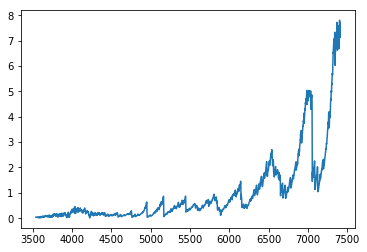

In [15]:
from matplotlib import pyplot
from mangadap.util.fileio import read_template_spectrum
test_file = '../data/spectral_templates/miles_cluster/MILES_cluster_group_01.fits'
wave, flux = read_template_spectrum(test_file)
pyplot.plot(wave, flux)

This works because the fits files for the template spectra have a specific format:

In [16]:
help(read_template_spectrum)

Help on function read_template_spectrum in module mangadap.util.fileio:

read_template_spectrum(filename, data_ext=None, ivar_ext=None, sres_ext=None, log10=False)
    Read a template spectrum.
    
    Template spectra are "raw format" files with template data and are,
    at minimum, expected to have the following components::
    
        hdu[0].header['CRVAL1']
        hdu[0].header['CRPIX1']
        hdu[0].header['CDELT1']
        hdu[data_ext].data
    
    The latter has the flux data.  If `log10` is true, the wavelength
    solution above is expected to be in log wavelengths.
    
    Args:
        filename (str): Name of the fits file to read.
        data_ext (str): (**Optional**) Name of the extension with the
            flux data.  If None, default is 0.
        ivar_ext (str): (**Optional**) Name of the extension with the
            inverse variance data.  If None, no inverse data are
            returned.
        sres_ext (str): (**Optional**) Name of the extension with

The template libraries are prepared for fitting using the `TemplateLibrary` class.  Again, there is a function that will let you know what template libraries are available:

In [14]:
from mangadap.proc.templatelibrary import available_template_libraries
lib = available_template_libraries()
print([ l['key'] for l in lib])

['BC03', 'CKC', 'CKCL', 'M11ELODIE', 'M11MARCS', 'M11MILES', 'M11STELIB', 'M11STELIBZSOL', 'MILES', 'MILESAVG', 'MILESHC', 'MILESTHIN', 'MIUSCAT', 'MIUSCATTHIN', 'STELIB']


These are defined by the configuration files in `./python/mangadap/config/spectral_templates`.  The file for the MILESHC library looks like this:
```
[Path]
 dapsrc           = ${MANGADAP_DIR}

[default]
 key              = MILESHC
 file_search      = ${Path:dapsrc}/data/spectral_templates/miles_cluster/*.fits
 fwhm             = 2.50
 sres_ext
 in_vacuum        = False
 wave_limit       = 3575, 7400
 lower_flux_limit = 0.0
 log10            = False
```

And you can construct the templates for this library using the `TemplateLibrary` class.

--------------------------------------------------
Template library output path: None
Template library output file: None
Found 42 MILESHC templates
Maximum number of wavelength channels: 4300
Attempting to build raw data ...
... done
Matching sampling ... 
... done
After resampling (target): 2.5e-05
After resampling (calculated): 2.499999999999995e-05
--------------------------------------------------
Number of templates: 42


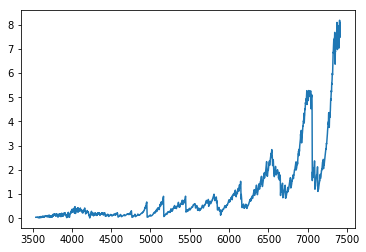

In [17]:
from mangadap.proc.templatelibrary import TemplateLibrary
sc_tpl = TemplateLibrary('MILESHC', match_to_drp_resolution=False,
                         velscale_ratio=4, spectral_step=1e-4, log=True, hardcopy=False)
print('Number of templates: {0}'.format(sc_tpl.ntpl))
pyplot.plot(sc_tpl['WAVE'].data, sc_tpl['FLUX'].data[0,:])

To add another library, you have to tell the DAP where it is and some of its properties using the `TemplateLibraryDef` object.  For the MILESHC library from above, the `TemplateLibraryDef` object is defined using the configuration file.  To add a new library, let's first convert a MaStar spectrum into a template that the DAP can read:

In [18]:
from mangadap.util.constants import DAPConstants
from mangadap.util.filter import interpolate_masked_vector

def create_mastar_template_spectrum():
    output_file = 'mastar-8047-9101-tpl.fits'

    hdu = fits.open('mastar-LOG-8047-9101.fits.gz')
    wave = hdu['MASTAR'].data['WAVE'].ravel()
    flux = hdu['MASTAR'].data['FLUX'].ravel()
    sres = interpolate_masked_vector(numpy.ma.power(DAPConstants.sig2fwhm
                                        * hdu['MASTAR'].data['PREDISP'].ravel() / wave, -1))

    hdr = fits.Header()
    hdr['CRPIX1'] = 1
    hdr['CRVAL1'] = numpy.log10(wave[0])
    hdr['CDELT1'] = numpy.diff(numpy.log10(wave[:2]))[0]
    hdr['CD1_1'] = hdr['CDELT1']
    fits.HDUList([ fits.PrimaryHDU(flux, header=hdr),
                   fits.ImageHDU(sres, name='SPECRES')]).writeto(output_file, overwrite=True)

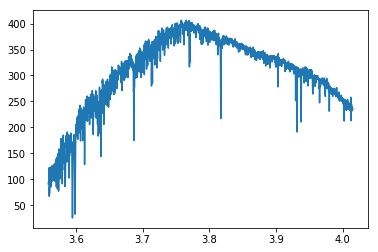

In [19]:
create_mastar_template_spectrum()
wave, flux, sres = read_template_spectrum('mastar-8047-9101-tpl.fits', sres_ext='SPECRES')
pyplot.plot(wave, flux)

In [21]:
from mangadap.proc.templatelibrary import TemplateLibraryDef
tpllib_list = [ TemplateLibraryDef('MaStar',
                                   file_search='mastar-8047-9101-tpl.fits',
                                   sres_ext='SPECRES',
                                   in_vacuum=True,
                                   log10=True) ]
print(tpllib_list[0])

       Parameter                      Value  Default        Type  Callable
--------------------------------------------------------------------------
             key                     MaStar     None         str     False
     file_search  mastar-8047-9101-tpl.fits     None         str     False
            fwhm                       None     None  int, float     False
        sres_ext                    SPECRES     None         str     False
       in_vacuum                       True     None        bool     False
      wave_limit                       None     None     ndarray     False
lower_flux_limit                       None     None  int, float     False
           log10                       True     None        bool     False



--------------------------------------------------
Template library output path: None
Template library output file: None
Found 1 MaStar templates
Maximum number of wavelength channels: 4563
Attempting to build raw data ...
... done
Matching sampling ... 
... done
After resampling (target): 2.5e-05
After resampling (calculated): 2.500000000000003e-05
--------------------------------------------------


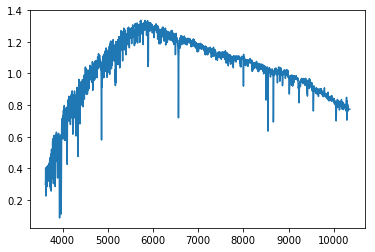

In [22]:
sc_tpl = TemplateLibrary('MaStar', tpllib_list=tpllib_list, match_to_drp_resolution=False,
                         velscale_ratio=4, spectral_step=1e-4, log=True, hardcopy=False)
pyplot.plot(sc_tpl['WAVE'].data, sc_tpl['FLUX'].data[0,:])

Or maybe you just want a set of old SSPs from MIUSCAT:

--------------------------------------------------
Template library output path: None
Template library output file: None
Found 4 OLDSSPs templates
Maximum number of wavelength channels: 6672
Attempting to build raw data ...
... done
Matching sampling ... 
... done
After resampling (target): 2.5e-05
After resampling (calculated): 2.4999999999999923e-05
--------------------------------------------------
Number of templates: 4


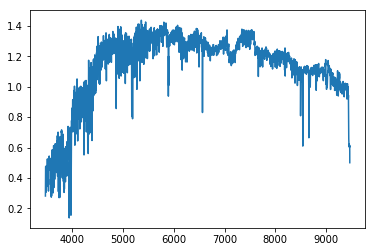

In [23]:
file_search = os.path.join(os.environ['MANGADAP_DIR'], 'data', 'spectral_templates',
                           'miuscat', '*T10.0000.fits')
tpllib_list += [ TemplateLibraryDef('OLDSSPs',
                                     file_search=file_search,
                                     fwhm=2.51,
                                     in_vacuum=False,
                                     wave_limit=numpy.array([3480, 9430]),
                                     log10=False) ]
sc_tpl = TemplateLibrary('OLDSSPs', tpllib_list=tpllib_list, match_to_drp_resolution=False,
                         velscale_ratio=4, spectral_step=1e-4, log=True, hardcopy=False)
print('Number of templates: {0}'.format(sc_tpl.ntpl))
pyplot.plot(sc_tpl['WAVE'].data, sc_tpl['FLUX'].data[0,:])


# Adding a new emission line to fit

Although it makes things a little onerous, the principles shown above for the template libraries is the same for how you define the set of emission lines to fit.  I.e., you need a file with the data and a file that tells the DAP where to find the data.  For the emission lines, the file with the data is an SDSS par file that lives in the `./data/emission_lines/` directory and the associated configuration files live in the `./python/mangadap/config/emission_lines` directory.

The emission lines fit during MPL-7/DR15 are in `./data/emission_lines/elpmiles.par` and the config file, `.python/mangadap/config/emission_lines/elpmiles.ini`, looks like this:
```
[Path]
 dapsrc           = ${MANGADAP_DIR}

[default]
 key              = ELPMILES
file_path = ${Path:dapsrc}/data/emission_lines/elpmiles.par
```

Again, you can find out the available emission-line databases as follows:

In [ ]:
from mangadap.par.emissionlinedb import available_emission_line_databases
dbs = available_emission_line_databases()
print([db['key'] for db in dbs])

In [ ]:
from mangadap.par.emissionlinedb import EmissionLineDB
emldb = EmissionLineDB('ELPMILES')
emldb['name']